In [12]:
import gym
import random, math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
from scripts.reinforce_rwd2go import rollout, make_pref_dataset
from scripts.utils import pref_save, pref_load
from scripts.utils import plot_loss_rewards


from scripts.model import getPolicy
import pickle

import torch
import torch.nn.functional as F
import copy


%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [13]:
SEED=0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

ENV_NAME = 'CartPole-v0'

env = gym.make(ENV_NAME)

K = 1000

POLICY1_NAME = "policies/policy1.pth"
POLICY2_NAME = "policies/policy2_with_mean.pth"
pref_data = pref_load(f"pref_data/pref_data_{K}_{ENV_NAME}.pickle")

/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Beta= 0.1


/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Epoch:  1 loss= 0.6931537985801697 , mean return= 122.66666666666667
Epoch:  2 loss= 0.6454741954803467 , mean return= 126.33333333333333
Epoch:  3 loss= 0.6008369326591492 , mean return= 138.33333333333334
Epoch:  4 loss= 0.5592154860496521 , mean return= 146.66666666666666
Epoch:  5 loss= 0.5205546617507935 , mean return= 179.33333333333334
Epoch:  6 loss= 0.48479655385017395 , mean return= 190.0
Epoch:  7 loss= 0.4518444538116455 , mean return= 155.0
Epoch:  8 loss= 0.4216269850730896 , mean return= 100.0
Epoch:  9 loss= 0.3941164016723633 , mean return= 199.0
Epoch:  10 loss= 0.3693251609802246 , mean return= 200.0
Epoch:  11 loss= 0.34724345803260803 , mean return= 141.66666666666666
Epoch:  12 loss= 0.32784008979797363 , mean return= 176.66666666666666
Epoch:  13 loss= 0.31104591488838196 , mean return= 164.66666666666666
Epoch:  14 loss= 0.29673993587493896 , mean return= 183.66666666666666
Epoch:  15 loss= 0.2847632169723511 , mean return= 156.66666666666666
Epoch:  16 loss= 0.

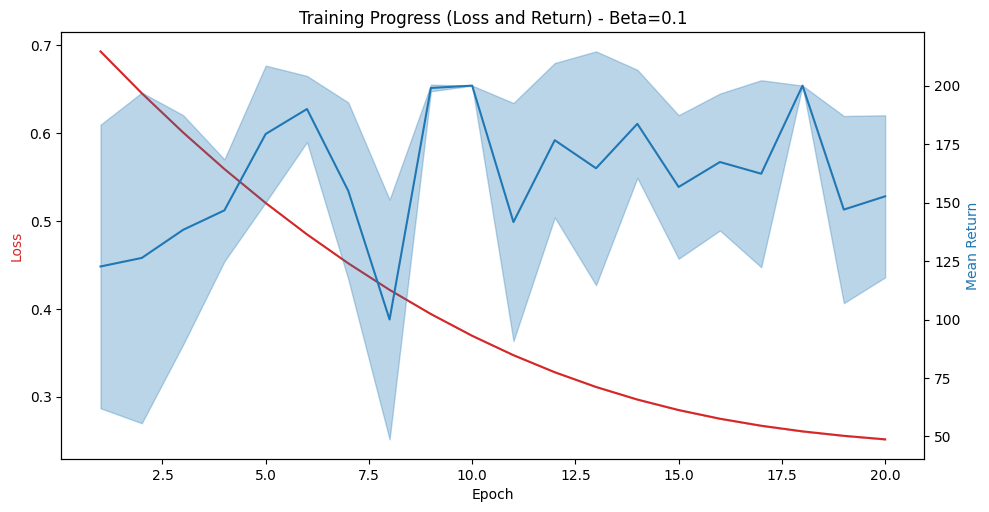

In [14]:
def trajectory_logprob(pi, states, actions):
    logp = torch.tensor(0., device=device)
    for s, a in zip(states, actions):
        s_t = torch.tensor(s, dtype=torch.float32, device=device)
        probs = pi(s_t.unsqueeze(0)).squeeze(0)      # shape [action_dim]
        logp += torch.log(probs[a])
    return logp

def copyPolicy(policy):
    pi_ref = copy.deepcopy(policy).to(device)

    for p in pi_ref.parameters():
        p.requires_grad = False

    return pi_ref


beta      = 0.1
lr        = 5e-3
#maybe we can have diff plots for diff betas and diff lr to see how they change things?
epochs    = 20
print("Beta=", beta)

policy1 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy1.load_state_dict(torch.load(POLICY1_NAME))

policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy2.load_state_dict(torch.load(POLICY2_NAME))

policy = copy.deepcopy(policy2).to(device)
pi_ref = copyPolicy(policy)
optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

losses = []
mean_returns = []
std_returns = []

random.seed(42)

for epoch in range(1, epochs + 1):
    total_loss = 0.0
    
    for s0, tau_plus, tau_minus in pref_data:
        logp_pos = trajectory_logprob(policy, tau_plus["states"], tau_plus["actions"])
        logp_neg = trajectory_logprob(policy, tau_minus["states"], tau_minus["actions"])
        logp_ref_pos = trajectory_logprob(pi_ref, tau_plus["states"], tau_plus["actions"])
        logp_ref_neg = trajectory_logprob(pi_ref, tau_minus["states"], tau_minus["actions"])

        diff = beta * (logp_pos - logp_ref_pos) - beta * (logp_neg - logp_ref_neg)
        total_loss += -F.logsigmoid(diff)
    
    total_loss = total_loss / len(pref_data)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    loss_value = total_loss.detach().numpy().item()
    losses.append(loss_value)
    
    returns = []
    for _ in range(3):
        seed = random.randint(0, 100000)
        state, done, total_r = env.reset(seed=seed), False, 0.0
        while not done:
            with torch.no_grad():
                action, _ = policy.act(state)
            state, r, done, _ = env.step(action)
            total_r += r
        returns.append(total_r)

    returns = np.array(returns)
    mean_returns.append(returns.mean())
    std_returns.append(returns.std())

    print("Epoch: ", epoch, "loss=", loss_value, ", mean return=", returns.mean())

mean_returns = np.array(mean_returns)
std_returns = np.array(std_returns)

x = list(range(1, epochs + 1))

fig, ax1 = plt.subplots(figsize=(10,5))
color = 'tab:red'
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color)
ax1.plot(x, losses, color=color, label="Loss")
ax1.fill_between(x, losses, losses, color=color, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("Mean Return", color=color)
ax2.plot(x, mean_returns, color=color, label="Mean Return")
ax2.fill_between(x, mean_returns - std_returns, mean_returns + std_returns, color=color, alpha=0.3)

fig.tight_layout()
plt.title(f"Training Progress (Loss and Return) - Beta={beta}")


plt.show()

In [15]:
# def trajectory_logprob(pi, states, actions):
#     logp = torch.tensor(0., device=device)
#     for s, a in zip(states, actions):
#         s_t = torch.tensor(s, dtype=torch.float32, device=device)
#         probs = pi(s_t.unsqueeze(0)).squeeze(0)      # shape [action_dim]
#         logp += torch.log(probs[a])
#     return logp

# def copyPolicy(policy):
#     pi_ref = copy.deepcopy(policy).to(device)

#     for p in pi_ref.parameters():
#         p.requires_grad = False

#     return pi_ref


# fig, axes = plt.subplots(2, 2, figsize=(15,10))
# betas      = [0.25, 0.5, 0.75, 1]
# lr        = 1e-2
# #maybe we can have diff plots for diff betas and diff lr to see how they change things?
# epochs    = 30

# for i, beta in enumerate(betas):
#     print("Beta=", beta)

#     policy1 = getPolicy(ENV_NAME=ENV_NAME).to(device)
#     policy1.load_state_dict(torch.load(POLICY1_NAME))

#     policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
#     policy2.load_state_dict(torch.load(POLICY2_NAME))

#     policy = copy.deepcopy(policy2).to(device)
#     pi_ref = copyPolicy(policy)
#     optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

#     losses = []
#     mean_returns = []
#     std_returns = []

#     random.seed(42)

#     for epoch in range(1, epochs + 1):
#         total_loss = 0.0
        
#         for s0, tau_plus, tau_minus in pref_data:
#             logp_pos = trajectory_logprob(policy, tau_plus["states"], tau_plus["actions"])
#             logp_neg = trajectory_logprob(policy, tau_minus["states"], tau_minus["actions"])
#             logp_ref_pos = trajectory_logprob(pi_ref, tau_plus["states"], tau_plus["actions"])
#             logp_ref_neg = trajectory_logprob(pi_ref, tau_minus["states"], tau_minus["actions"])

#             diff = beta * (logp_pos - logp_ref_pos) - beta * (logp_neg - logp_ref_neg)
#             total_loss += -F.logsigmoid(diff)
        
#         total_loss = total_loss / len(pref_data)

#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()

#         loss_value = total_loss.detach().numpy().item()
#         losses.append(loss_value)
#         print("Epoch: ", epoch, "loss=", loss_value)
        
#         returns = []
#         for _ in range(3):
#             seed = random.randint(0, 100000)
#             state, done, total_r = env.reset(seed=seed), False, 0.0
#             while not done:
#                 with torch.no_grad():
#                     action, _ = policy.act(state)
#                 state, r, done, _ = env.step(action)
#                 total_r += r
#             returns.append(total_r)

#         returns = np.array(returns)
#         mean_returns.append(returns.mean())
#         std_returns.append(returns.std())

#     mean_returns = np.array(mean_returns)
#     std_returns = np.array(std_returns)

#     x = list(range(1, epochs + 1))


#     ax1 = axes[i // 2, i % 2]
#     color = 'tab:red'
#     ax1.set_xlabel("Epoch")
#     ax1.set_ylabel("Loss", color=color)
#     ax1.plot(x, losses, color=color, label="Loss")
#     ax1.fill_between(x, losses, losses, color=color, alpha=0.3)

#     ax2 = ax1.twinx()
#     color = 'tab:blue'
#     ax2.set_ylabel("Mean Return", color=color)
#     ax2.plot(x, mean_returns, color=color, label="Mean Return")
#     ax2.fill_between(x, mean_returns - std_returns, mean_returns + std_returns, color=color, alpha=0.3)

#     fig.tight_layout()
#     plt.title(f"Training Progress (Loss and Return) - Beta={beta}")


# plt.show()